In [ ]:
%load_ext autoreload
%autoreload 2
from get_mmap import get_mmap
import random

# Setup the necessary paths and parameters
fmap_profile = 'e2_bat_fb_alpha_raw_s_0_3071.raw'
fmap_attack = 'e2_bat_fb_beta_raw_s_0_3071.raw'
data_title = 'Templates A2D AB'
path_data = 'results/'
name_data = 'a2d_ab_bat_fb_templates_dlinear_n1000r_slr_g1000_r10.pkl'
rand_iter = 10
n_profile = 1000 # ensure that: n_profile + n_attack < nr_blocks
nr_traces_vec = list(range(1, 11)) + list(range(20, 101, 10)) + [200, 500, 1000]
inbytes = list(range(256))
atype = 'mvn'

In [ ]:
# Load file
print('Mapping data for profile...')
mmap_data_profile, metadata_profile = get_mmap(fmap_profile)
print('Mapping data for attack...')
mmap_data_attack, metadata_attack = get_mmap(fmap_attack)
print('Done mapping data')

In [ ]:
# Select idx for profile/attack
nr_blocks = 3072
idx = list(range(1, nr_blocks + 1))
idx_profile = [x for x in idx if x % 3 == 1 or x % 3 == 2]
idx_profile = random.choices(idx_profile, k=n_profile)  # Allows duplicates
# idx_profile = random.sample(idx_profile, n_profile) # This doesn't allow duplicates
idx_attack = [x for x in idx if x % 3 == 0]

# Set up attack/result cells
results = [None] * 6

In [ ]:
from run_template_attack import run_template_attack

cmethod = 'LDA'
cparams = {
    'lda_dimensions': 4,
    'lda_threshold': 0.95
}
discriminant = 'linearnocov'

results[0] = run_template_attack(
    mmap_data_profile, metadata_profile, idx_profile, mmap_data_attack, metadata_attack,
    idx_attack, inbytes, atype, cmethod, cparams, discriminant, rand_iter, nr_traces_vec)

In [ ]:
# Run attack for PCA
cmethod = 'PCA'
cparams = {
    'pca_threshold': 0.95,
    'pca_alternate': 0,
    'pca_dimensions': 4
}
discriminant = 'linear'
results[1] = run_template_attack(
    mmap_data_profile, metadata_profile, idx_profile, mmap_data_attack, metadata_attack,
    idx_attack, inbytes, atype, cmethod, cparams, discriminant, rand_iter, nr_traces_vec)

In [ ]:
# Run attack for 1ppc
cmethod = 'sample'
cparams = {
    'curve': 'dom',
    'sel': '1ppc',
    'p1': 240
}
discriminant = 'linear'
results[2] = run_template_attack(
    mmap_data_profile, metadata_profile, idx_profile, mmap_data_attack, metadata_attack,
    idx_attack, inbytes, atype, cmethod, cparams, discriminant, rand_iter, nr_traces_vec)

In [ ]:
# Run attack for 3ppc
cmethod = 'sample'
cparams = {
    'curve': 'dom',
    'sel': '3ppc',
    'p1': 240
}
discriminant = 'linear'
results[3] = run_template_attack(
    mmap_data_profile, metadata_profile, idx_profile, mmap_data_attack, metadata_attack,
    idx_attack, inbytes, atype, cmethod, cparams, discriminant, rand_iter, nr_traces_vec)

In [ ]:
# Run attack for 20ppc
cmethod = 'sample'
cparams = {
    'curve': 'dom',
    'sel': '20ppc',
    'p1': 240
}
discriminant = 'linear'
results[4] = run_template_attack(
    mmap_data_profile, metadata_profile, idx_profile, mmap_data_attack, metadata_attack,
    idx_attack, inbytes, atype, cmethod, cparams, discriminant, rand_iter, nr_traces_vec)

In [ ]:
# Run attack for allap
cmethod = 'sample'
cparams = {
    'curve': 'dom',
    'sel': 'allap',
    'p1': 0.95
}
discriminant = 'linear'
results[5] = run_template_attack(
    mmap_data_profile, metadata_profile, idx_profile, mmap_data_attack, metadata_attack,
    idx_attack, inbytes, atype, cmethod, cparams, discriminant, rand_iter, nr_traces_vec)

In [ ]:
import os
import pickle

# Save data to disk so you can prevent wasting time
print('All done, saving data...\n')
os.makedirs(path_data, exist_ok=True)

with open(os.path.join(path_data, name_data), 'wb') as f:
    pickle.dump(results, f)

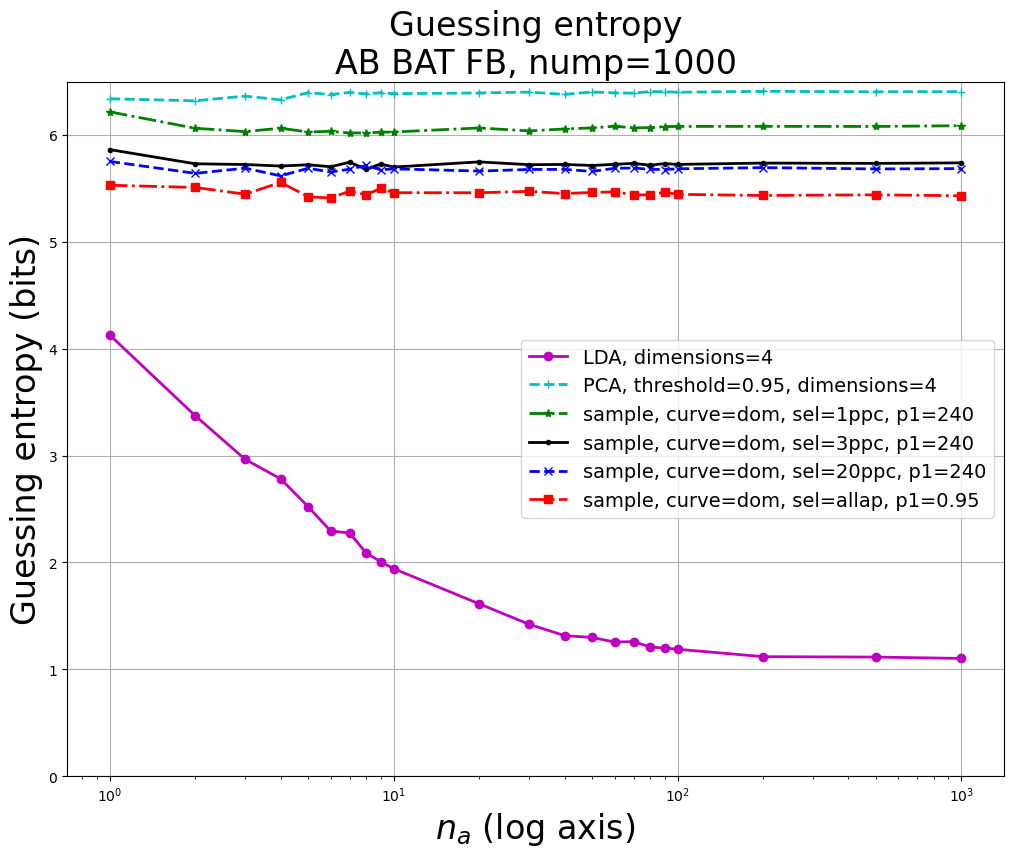

In [21]:
from do_show_results_templates_a2_bat_fb import get_ge_from_success_info, get_line_properties_templates, make_figures_ge
import matplotlib.pyplot as plt
import numpy as np

with open(os.path.join(path_data, name_data), 'rb') as f:
    data = pickle.load(f)

fdata = 'results/a2d_ab_bat_fb_templates_dlinear_n1000r_slr_g1000_r10.pkl'
rpath = 'figures/'
font_size = 24
options = 'gL'
yrange = [0, 6.5]
# yrange = [0, 7]
nr_traces_vec = list(range(1, 11)) + list(range(20, 101, 10)) + [200, 500, 1000]
len_na_vec = len(nr_traces_vec)

# Reset environment
plt.close('all')

nump = data[0]['x_profile'].shape[0]
rand_iter = data[0]['rand_iter']
nr_exp_ab = len(data)
L = [None] * nr_exp_ab
G = np.zeros((nr_exp_ab, len_na_vec))
slines_ab = [None] * nr_exp_ab
style = 'fancy'

for k in range(nr_exp_ab):
    cmethod = data[k]['cmethod']
    if cmethod == 'sample':
        L[k] = f"{cmethod}, curve={data[k]['cparams']['curve']}, sel={data[k]['cparams']['sel']}, p1={data[k]['cparams']['p1']}"
    elif cmethod == 'PCA':
        L[k] = f"{cmethod}, threshold={data[k]['cparams']['pca_threshold']}, dimensions={data[k]['cparams']['pca_dimensions']}"
    elif cmethod == 'LDA':
        L[k] = f"{cmethod}, dimensions={data[k]['cparams']['lda_dimensions']}"

    g = get_ge_from_success_info(data[k]['success_info'], nr_traces_vec)
    G[k, :] = g['joint']
    slines_ab[k] = get_line_properties_templates(k, style)

# Plot results
title_results = f"AB BAT FB, nump={nump}"
rprefix = f"a2d_ab_bat_fb_dlinear_n{nump}r_ls_r{rand_iter}_"
make_figures_ge(G, nr_traces_vec, rpath, rprefix, title_results, L, font_size, slines_ab, options, yrange)
